In [67]:
# 1. For reading JSON and handling paths
import json
import os
import argparse

# 2. For data manipulation and analysis
import pandas as pd
import numpy as np

# 3. For plotting 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\neeraja bapatla\appdata\local\programs\python\python311\lib\site-packages\dlib-19.24.99-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:

# Load JSON file
with open('user-wallet-transactions.json', 'r') as f:
    data = json.load(f)


In [26]:
# Convert to DataFrame
df = pd.json_normalize(data)

In [29]:
# Preview the structure
print("Number of transactions:", len(df))
columns = df.columns.tolist()
print("Total no of features:",len(columns))
print(columns)
print(df.head(5))

wallet = "0x00000000001accfa9cef68cf5371a23025b6d4b6"
df_wallet = df[df['userWallet'] == wallet]
print(df_wallet[['action', 'actionData.amount']])


Number of transactions: 100000
Total no of features: 38
['userWallet', 'network', 'protocol', 'txHash', 'logId', 'timestamp', 'blockNumber', 'action', '__v', '_id.$oid', 'actionData.type', 'actionData.amount', 'actionData.assetSymbol', 'actionData.assetPriceUSD', 'actionData.poolId', 'actionData.userId', 'createdAt.$date', 'updatedAt.$date', 'actionData.toId', 'actionData.borrowRateMode', 'actionData.borrowRate', 'actionData.variableTokenDebt', 'actionData.stableTokenDebt', 'actionData.callerId', 'actionData.useATokens', 'actionData.repayerId', 'actionData.liquidatorId', 'actionData.collateralAmount', 'actionData.collateralAssetPriceUSD', 'actionData.principalAmount', 'actionData.borrowAssetPriceUSD', 'actionData.collateralReserveId', 'actionData.collateralReserveSymbol', 'actionData.principalReserveId', 'actionData.principalReserveSymbol', 'amount_token', 'asset_price_usd', 'usd_value']
                                   userWallet  network protocol  \
0  0x00000000001accfa9cef68cf537

In [28]:
# 4. Convert Amounts from Token Units to USD

# Convert amount from string to float (in tokens)
df['amount_token'] = df['actionData.amount'].astype(float) / (10 ** 18)

# Convert assetPriceUSD from string to float
df['asset_price_usd'] = df['actionData.assetPriceUSD'].astype(float)

# Compute USD value of each transaction
df['usd_value'] = df['amount_token'] * df['asset_price_usd']

# Optional: inspect
print(df[['userWallet', 'action', 'amount_token', 'asset_price_usd', 'usd_value']].head())


                                   userWallet            action  amount_token  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6           deposit  2.000000e-09   
1  0x000000000051d07a4fb3bd10121a343d85818da6           deposit  1.450000e+02   
2  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit  1.000000e-03   
3  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit  4.000000e-03   
4  0x0000000000e189dd664b9ab08a33c4839953852c  redeemunderlying  5.015480e-13   

   asset_price_usd     usd_value  
0         0.993832  1.987664e-09  
1         1.970307  2.856945e+02  
2         0.922377  9.223773e-04  
3         1.057483  4.229933e-03  
4         1.002130  5.026161e-13  


In [30]:
# 5. Aggregate Wallet-Level Features

# 5.1 Deposit Features
deposit_df = df[df['action'] == 'deposit']
deposit_agg = deposit_df.groupby('userWallet')['usd_value'].agg(['count', 'sum']).reset_index()
deposit_agg.columns = ['userWallet', 'num_deposits', 'total_deposit_usd']

# 5.2 Borrow Features
borrow_df = df[df['action'] == 'borrow']
borrow_agg = borrow_df.groupby('userWallet')['usd_value'].agg(['count', 'sum']).reset_index()
borrow_agg.columns = ['userWallet', 'num_borrows', 'total_borrow_usd']

# 5.3 Repay Features
repay_df = df[df['action'] == 'repay']
repay_agg = repay_df.groupby('userWallet')['usd_value'].agg(['count', 'sum']).reset_index()
repay_agg.columns = ['userWallet', 'num_repays', 'total_repay_usd']

# 5.4 Withdrawals (redeemunderlying)
redeem_df = df[df['action'] == 'redeemunderlying']
redeem_agg = redeem_df.groupby('userWallet')['usd_value'].sum().reset_index()
redeem_agg.columns = ['userWallet', 'total_withdraw_usd']

# 5.5 Liquidation Events
liquid_df = df[df['action'] == 'liquidationcall']
liquid_agg = liquid_df.groupby('userWallet').size().reset_index(name='num_liquidations')


In [31]:
# Start from deposit data
features = deposit_agg.copy()

# Merge all other features
features = features.merge(borrow_agg, on='userWallet', how='left')
features = features.merge(repay_agg, on='userWallet', how='left')
features = features.merge(redeem_agg, on='userWallet', how='left')
features = features.merge(liquid_agg, on='userWallet', how='left')


In [32]:
# Fill missing values with 0 (wallets that didn’t perform certain actions)
features.fillna(0, inplace=True)


In [33]:
# Repay-to-Borrow Ratio
features['repay_to_borrow_ratio'] = features.apply(
    lambda row: row['total_repay_usd'] / row['total_borrow_usd']
    if row['total_borrow_usd'] > 0 else 0,
    axis=1
)

# Net Contribution = deposits + repays - borrows - withdrawals
features['net_contribution_usd'] = (
    features['total_deposit_usd'] +
    features['total_repay_usd'] -
    features['total_borrow_usd'] -
    features['total_withdraw_usd']
)


In [34]:
print(features.head())

                                   userWallet  num_deposits  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6             1   
1  0x000000000051d07a4fb3bd10121a343d85818da6             1   
2  0x000000000096026fb41fc39f9875d164bd82e2dc             2   
3  0x0000000002032370b971dabd36d72f3e5a7bf1ee           250   
4  0x000000000a38444e0a6e37d3b630d7e855a7cb13             7   

   total_deposit_usd  num_borrows  total_borrow_usd  num_repays  \
0       1.987664e-09          0.0      0.000000e+00         0.0   
1       2.856945e+02          0.0      0.000000e+00         0.0   
2       5.152311e-03          0.0      0.000000e+00         0.0   
3       2.065773e+05         15.0      6.029762e+04         4.0   
4       1.839067e+04          8.0      1.163143e-08         5.0   

   total_repay_usd  total_withdraw_usd  num_liquidations  \
0     0.000000e+00            0.000000               0.0   
1     0.000000e+00            0.000000               0.0   
2     0.000000e+00            0.000000

In [35]:
def proxy_score(row):
    score = 500  # Start from neutral base
    # Positive Contributions
    # Reward deposits (up to $10K)
    score += min(row['total_deposit_usd'], 10_000) * 0.04

    # Reward high repayment discipline
    score += min(row['repay_to_borrow_ratio'], 2.0) * 80

    # Reward net contribution (up to $5K)
    score += min(row['net_contribution_usd'], 5_000) * 0.05

    # Bonus for activity: frequent borrows and repays (but not too many)
    score += min(row['num_borrows'], 10) * 2
    score += min(row['num_repays'], 10) * 2
    # Penaltie
    # Penalize high total borrow if not well repaid
    if row['repay_to_borrow_ratio'] < 0.5 and row['total_borrow_usd'] > 100:
        score -= 50

    # Penalize liquidations heavily
    score -= row['num_liquidations'] * 100

    # Penalize negative contribution
    if row['net_contribution_usd'] < 0:
        score += row['net_contribution_usd'] * 0.1  # subtracts

    # Final Bounds
    return int(np.clip(score, 0, 1000))


In [37]:
features['proxy_score'] = features.apply(proxy_score, axis=1)
print(features['proxy_score'].head(5))

0     500
1     525
2     500
3    1000
4    1000
Name: proxy_score, dtype: int64


In [40]:
from sklearn.model_selection import train_test_split

# Drop ID columns and prepare features/target
X = features.drop(columns=['userWallet', 'proxy_score'])
y = features['proxy_score']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(features.columns.tolist())


['userWallet', 'num_deposits', 'total_deposit_usd', 'num_borrows', 'total_borrow_usd', 'num_repays', 'total_repay_usd', 'total_withdraw_usd', 'num_liquidations', 'repay_to_borrow_ratio', 'net_contribution_usd', 'proxy_score']


In [39]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [41]:
# Predict for all wallets
features['credit_score'] = model.predict(X)

# Clip and round scores to [0, 1000]
features['credit_score'] = features['credit_score'].clip(0, 1000).round().astype(int)


In [42]:
wallet_scores = features[['userWallet', 'credit_score']]
wallet_scores.to_json('wallet_scores.json', orient='records', indent=2)

features.to_csv('wallet_features_with_scores.csv', index=False)


In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)


# Step 4: Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 6.16
MSE: 392.83
R² Score: 0.99


In [66]:
import json

# Load the JSON file
with open('wallet_scores.json', 'r') as f:
    result = json.load(f)

# Print the first 5 entries
for entry in result[:5]:
    print(json.dumps(entry, indent=2))  


{
  "userWallet": "0x00000000001accfa9cef68cf5371a23025b6d4b6",
  "credit_score": 500
}
{
  "userWallet": "0x000000000051d07a4fb3bd10121a343d85818da6",
  "credit_score": 525
}
{
  "userWallet": "0x000000000096026fb41fc39f9875d164bd82e2dc",
  "credit_score": 500
}
{
  "userWallet": "0x0000000002032370b971dabd36d72f3e5a7bf1ee",
  "credit_score": 1000
}
{
  "userWallet": "0x000000000a38444e0a6e37d3b630d7e855a7cb13",
  "credit_score": 1000
}


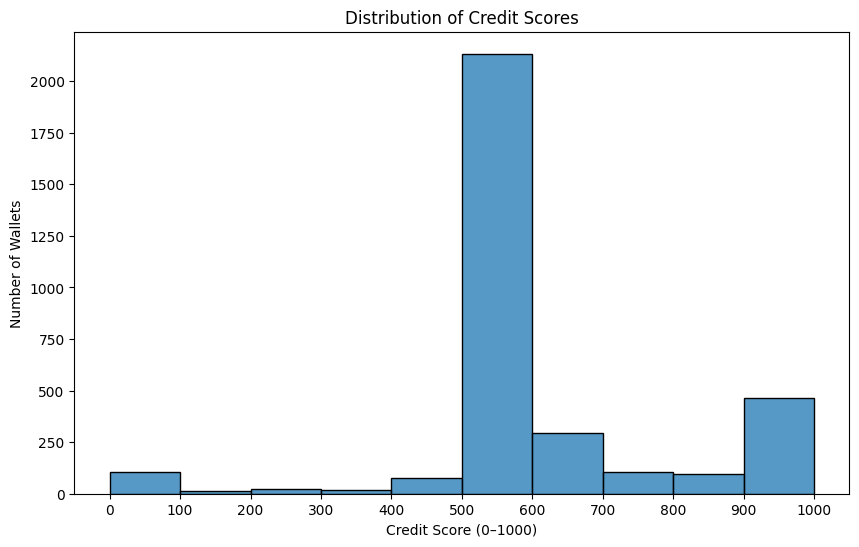

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(features['credit_score'], bins=10)
plt.xticks(np.arange(0, 1100, 100))
plt.title('Distribution of Credit Scores')
plt.xlabel('Credit Score (0–1000)')
plt.ylabel('Number of Wallets')
plt.show()


In [70]:
plt.savefig("score_distribution.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV file
features = pd.read_csv('wallet_features_with_scores.csv')

# Segment score ranges
low_score_wallets = features[features['credit_score'] <= 200]
high_score_wallets = features[features['credit_score'] >= 800]

# Select features to compare
key_features = [
    'num_deposits', 'num_borrows', 'num_repays', 'num_liquidations',
    'repay_to_borrow_ratio', 'total_deposit_usd', 'total_borrow_usd',
    'total_repay_usd', 'net_contribution_usd'
]

# Compute mean values
avg_features = pd.DataFrame({
    'Low Score': low_score_wallets[key_features].mean(),
    'High Score': high_score_wallets[key_features].mean()
})

# Print the values
print(avg_features.round(2))


                        Low Score  High Score
num_deposits                34.75       36.07
num_borrows                 23.68       16.76
num_repays                  20.20       12.81
num_liquidations             0.37        0.12
repay_to_borrow_ratio        0.58        0.55
total_deposit_usd      1343448.68   460180.43
total_borrow_usd        884252.25   247122.50
total_repay_usd         576792.48   173307.00
net_contribution_usd   -161741.73   122981.68


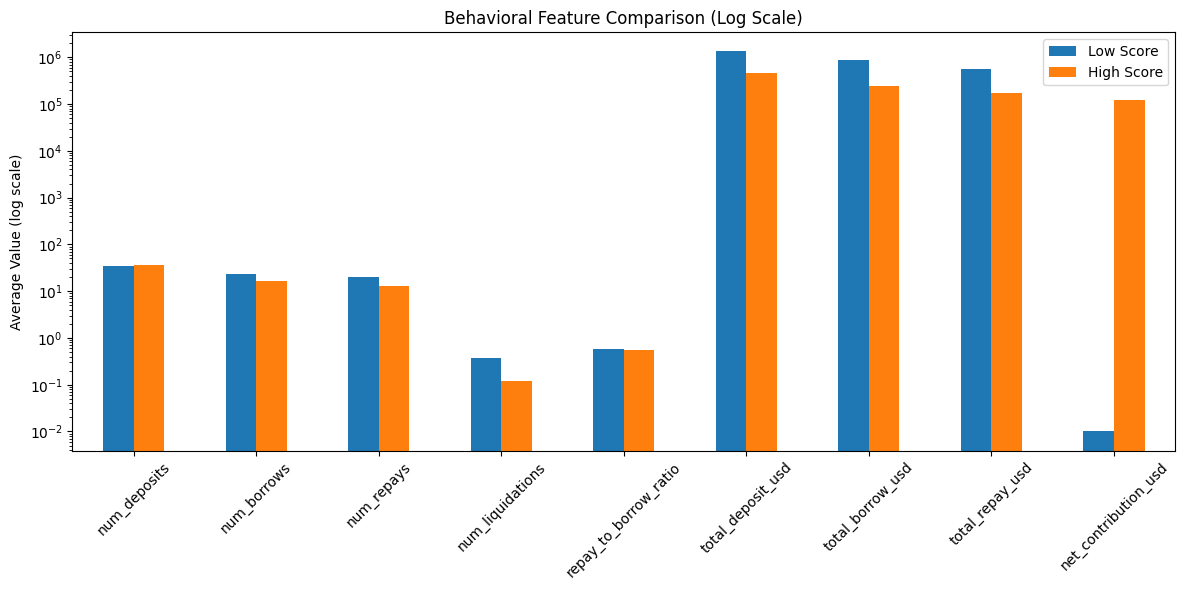

In [65]:
# Plotting
avg_features.replace(0, 0.01, inplace=True)  # avoid log(0)
avg_features[avg_features < 0] = 0.01        # avoid log of negatives

avg_features.plot(kind='bar', figsize=(12, 6), logy=True)
plt.title("Behavioral Feature Comparison (Log Scale)")
plt.ylabel("Average Value (log scale)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [72]:
plt.savefig("behavioral_comparison.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>